# Introduction to Machine Learning - project
## Stanford Car Body Type Classification

https://www.kaggle.com/datasets/mayurmahurkar/stanford-car-body-type-data - dataset

Import necessary libraries and moduels

In [1]:
import cv2
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from functools import partial
import keras.backend as K

Definition of every funtions used in project

In [39]:
modelsDir = 'NeuralNetwork'
dataDir = 'data'

def confMatrixMultiOutput(model, X_test, encoder_dict, labels_dict):

    # Predicted labels for test data
    predict = model.predict(X_test)

    # print(classification_report([labels_encoded_general_test, labels_encoded_small_test, labels_encoded_big_test, labels_encoded_finale_test],predict))

    predicted_labels = np.argmax(predict[3], axis=-1)


    precision = precision_score(labels_dict['final'], predicted_labels, average='weighted')
    recall = recall_score(labels_dict['final'], predicted_labels, average='weighted')
    f1 = f1_score(labels_dict['final'], predicted_labels, average='weighted')
    accuracy = accuracy_score(labels_dict['final'], predicted_labels)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recal: {recall}')
    print(f'F1 Score: {f1}')


    cm = confusion_matrix(labels_dict['final'], predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder_dict['final'].classes_, yticklabels=encoder_dict['final'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Final')
    plt.show()

    predicted_labels = np.argmax(predict[0], axis=-1)

    cm = confusion_matrix(labels_dict['general'], predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder_dict['general'].classes_, yticklabels=encoder_dict['general'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix General')
    plt.show()


    predicted_labels = np.argmax(predict[1], axis=-1)

    cm = confusion_matrix(labels_dict['small'], predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder_dict['small'].classes_, yticklabels=encoder_dict['small'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Small')
    plt.show()


    predicted_labels = np.argmax(predict[2], axis=-1)

    cm = confusion_matrix(labels_dict['big'], predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder_dict['big'].classes_, yticklabels=encoder_dict['big'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Big')
    plt.show()

def confMatrixSingle(model, X_test, y_test, encoder):
    predict = model.predict(X_test)

    predicted_labels = np.argmax(predict, axis=-1)
    precision = precision_score(y_test, predicted_labels, average='weighted')
    recall = recall_score(y_test, predicted_labels, average='weighted')
    f1 = f1_score(y_test, predicted_labels, average='weighted')
    accuracy = accuracy_score(y_test, predicted_labels)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recal: {recall}')
    print(f'F1 Score: {f1}')
    cm = confusion_matrix(y_test, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plotPrint(history):
    print(history.history)
    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)

        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right');
        plt.grid(True)


    else:        
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)
        if 'output_final_accuracy' in history.history:
            print('output_final_accuracy')
            ax1 = fig.add_subplot(122)
            ax1.plot(epochs, history.history['output_final_accuracy'], c='b', label='Train acc')
            ax1.plot(epochs, history.history['val_output_final_accuracy'], c='g', label='Valid acc')
            plt.legend(loc='lower right');
            plt.grid(True)
    plt.show()


def saveModel(model, model_name):
    dir = f'{modelsDir}/{model_name}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    model.save(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został zapisany pod nazwą: {model_name}")

def loadModel(model_name):
    loaded_model = tf.keras.models.load_model(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został wczytany z pliku: {model_name}")
    return loaded_model

def loadImage(imageDir, new=True):
    if (new): 
        csv_file = f'{dataDir}/new_stanford_cars_type.csv'
    else:
        csv_file = f'{dataDir}/stanford_cars_type.csv'

    img_folder = f'{dataDir}/{imageDir}'
    data_csv = pd.read_csv(csv_file)
    images_tab = []
    labels_string = []

    for index, row in data_csv.iterrows():
        filename = row['file_name']
        category = row['car_type']

        image_path = os.path.join(img_folder, filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images_tab.append(image)
        labels_string.append(category)
    images = np.array(images_tab)
    return (images,np.array(labels_string))

def loadImageGenerated(imageDir):

    csv_file = f'{dataDir}/generated/{imageDir}/informacje.csv'

    img_folder = f'{dataDir}/generated/{imageDir}/img'
    data_csv = pd.read_csv(csv_file)
    print(data_csv.columns)
    images_tab = []
    labels_string = []

    for index, row in data_csv.iterrows():
        filename = row['Nazwa_pliku']
        category = row['Klasa']

        image_path = os.path.join(img_folder, filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images_tab.append(image)
        labels_string.append(category)
    images = np.array(images_tab)
    return (images,np.array(labels_string))

def encodeLabel(labels_s):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_s)
    return (labels_encoded, label_encoder)


def preprocessImages(images):
    preprocessed_images = []
    for image in images:
        equalized_image = cv2.equalizeHist(np.uint8(image))
        normalized_image = equalized_image / 255.0
        preprocessed_images.append(normalized_image)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images

def resizeAndSaveImages(input_folder, output_folder, target_size=(255, 255)):
    output_folder = f'{dataDir}/{output_folder}'
    input_folder = f'{dataDir}/{input_folder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, target_size)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_image)


def generateFromOriginalImages(outputFlder, newSize=(256,256)):
    main_data_folder = f'{dataDir}/stanford_cars_type'

    output_folder = f'{dataDir}/{outputFlder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label in os.listdir(main_data_folder):
        label_folder = os.path.join(main_data_folder, label)
        
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)

            # Wyodrębnij tylko cyfry z początku nazwy
            numeric_prefix = re.match(r'^\d+', image_file).group()

            # Wczytaj obraz za pomocą OpenCV
            image = cv2.imread(image_path)

            # Przeskaluj obraz do nowego wymiaru (255x255) i zamień na skalę szarości
            image = cv2.resize(image, newSize)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Nazwa nowego pliku
            new_filename = f'{numeric_prefix}.jpg'
            new_image_path = os.path.join(output_folder, new_filename)

            # Zapisz przetworzony obraz
            cv2.imwrite(new_image_path, image)
            
def splitData(images,labels_encoded):
    imagesData = images.reshape(images.shape + (1,))
    X_train, X_test, y_train, y_test = train_test_split(imagesData, labels_encoded, test_size=0.2, random_state=1, stratify=labels_encoded)
    return (X_train, X_test, y_train, y_test)



def labelsPlot(labels_string):
    # Zliczenie etykiet
    label_counts = Counter(labels_string)

    print(label_counts)

    # Rozpakowanie nazw etykiet i ich liczności do wykresu słupkowego
    labels, counts = zip(*label_counts.items())

    # Generowanie wykresu słupkowego
    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Klasy etykiet')
    plt.ylabel('Liczba obrazów')
    plt.title('Rozkład klas etykiet')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

def generate_image_histogram_by_index(images_data, labels, index, bins=256):
    # Sprawdzenie poprawności indeksu
    if index < 0 or index >= len(images_data):
        print("Nieprawidłowy indeks")
        return
    image = images_data[index]
    max_value = np.max(image)
    if not(max_value > 1):
        image = image * 255.0
    height, width = image.shape[:2]

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Wybrane zdjęcie: {index}\nRozmiar: {width}x{height}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.hist(image.ravel(), bins, [0, 255])
    plt.title(f'Histogram wybranego zdjęcia {labels[index]}')
    plt.xlabel('Wartość piksela')
    plt.ylabel('Liczba pikseli')
    plt.grid()


    plt.tight_layout()
    plt.show()

def showImage(index):
    plt.imshow(images[index], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
    plt.axis('off')  # Wyłączenie osi
    plt.title(f"Obraz {index}")
    plt.show()

def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

def read_dataframe_from_csv(file_path):
    return pd.read_csv(file_path)


### Dogenerowanie zdjeć do równej liczebności 

In [16]:

images, labels = loadImage('128x128')
cnt = Counter(labels)
print (cnt)
# Ustal docelową liczebność klas
target_class_count = max(cnt.values())  # Dostosuj tę wartość do oczekiwanej liczby obrazów w każdej klasie
print(target_class_count)

# Inicjalizuj generator augmentacji danych
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Dla każdej klasy
for class_label in cnt.keys():  # Zastąp num_classes rzeczywistą liczbą klas
    # Wybierz obrazy danej klasy
    print(labels[labels == class_label])
    class_images = images[labels == class_label]

    # Oblicz liczbę obecnych obrazów w klasie
    current_count = len(class_images)
    print(current_count)
    # Oblicz, ile obrazów należy dodać
    images_to_generate = target_class_count - current_count
    if images_to_generate == 0:
     continue
    # Wygeneruj i zapisz dodatkowe obrazy
    generated_images = []
    for i in range(images_to_generate):
        # Wybierz losowy obraz z klasy
        random_image = class_images[np.random.choice(current_count)]
        random_image = cv2.cvtColor(random_image, cv2.COLOR_GRAY2RGB)
        # Zastosuj augmentację do obrazu
        augmented_image = datagen.random_transform(random_image)
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2GRAY)
        # Dodaj obraz do listy wygenerowanych obrazów
        generated_images.append(augmented_image)

    # Dodaj wygenerowane obrazy do danych treningowych
    images = np.concatenate([images, np.array(generated_images)])
    
    # Zaktualizuj etykiety
    labels = np.concatenate([labels, np.full(images_to_generate, class_label)])


output_folder = 'data/generated/128x128/'

# Stwórz folder, jeśli nie istnieje
os.makedirs(output_folder, exist_ok=True)
images_index = []
# Zapisz obrazy do folderu
for idx, generated_image in enumerate(images):

    filename = f"img/{idx}.jpg"
    images_index.append(f"{idx}.jpg")
    # Ścieżka do zapisu obrazu
    image_path = os.path.join(output_folder, filename)

    # Zapisz obraz
    cv2.imwrite(image_path, generated_image)

# Stwórz DataFrame pandas
df = pd.DataFrame({'Nazwa_pliku': images_index, 'Klasa': labels})

# Zapisz DataFrame do pliku CSV
csv_filename = 'informacje.csv'
csv_path = os.path.join(output_folder, csv_filename)
df.to_csv(csv_path, index=False)




Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})
1907
['Coupe' 'Coupe' 'Coupe' ... 'Coupe' 'Coupe' 'Coupe']
1088
['Sedan' 'Sedan' 'Sedan' ... 'Sedan' 'Sedan' 'Sedan']
1907
['Van' 'Van' 'Van' ... 'Van' 'Van' 'Van']
1513
['Convertible' 'Convertible' 'Convertible' ... 'Convertible' 'Convertible'
 'Convertible']
1036
['SUV' 'SUV' 'SUV' ... 'SUV' 'SUV' 'SUV']
1437


### Eksploracyjna analiza danych
Przed wygenerowaniem wykresu należy uruchomić poprzednią komórkę, która zawiera przetworzone obrazy
- Wykres przedstawiający rozkład klas etykiet
- Możliwość wyświetlenia dowolnego obrazu ze zbioru danych wraz z histogramem

   Unnamed: 0  file_name  car_code                             car_name  \
0           0  00001.jpg        14                  Audi TTS Coupe 2012   
1           1  00002.jpg         3                  Acura TL Sedan 2012   
2           2  00003.jpg        91           Dodge Dakota Club Cab 2007   
3           3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012   
4           4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   

     brand car_type                                   new_filename  
0     Audi    Coupe                  00001_Audi TTS Coupe 2012.jpg  
1    Acura    Sedan                  00002_Acura TL Sedan 2012.jpg  
2    Dodge      Cab           00003_Dodge Dakota Club Cab 2007.jpg  
3  Hyundai    Sedan     00004_Hyundai Sonata Hybrid Sedan 2012.jpg  
4     Ford      Cab  00005_Ford F-450 Super Duty Crew Cab 2012.jpg  
Counter({'Sedan': 1907, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036, 'Cab': 719, 'Other': 609, 'Hatchback': 554, 'Wagon': 291, 'Van

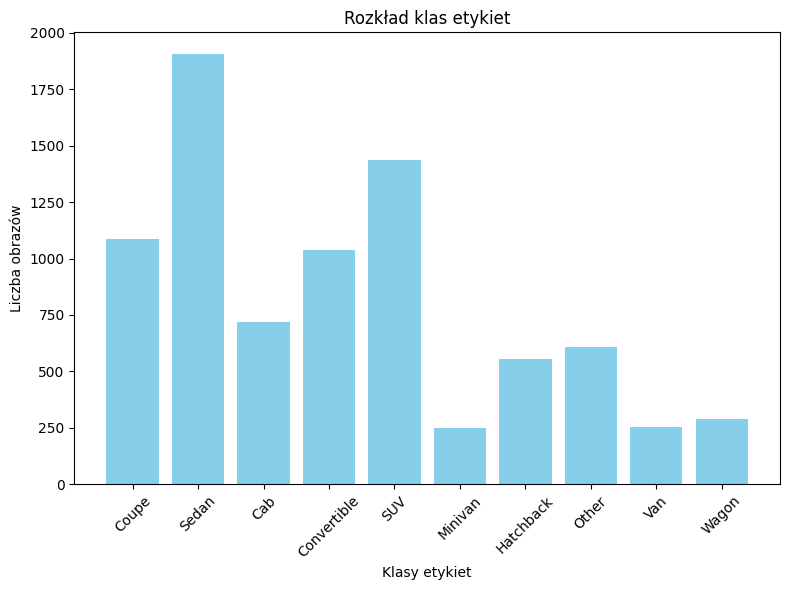

Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


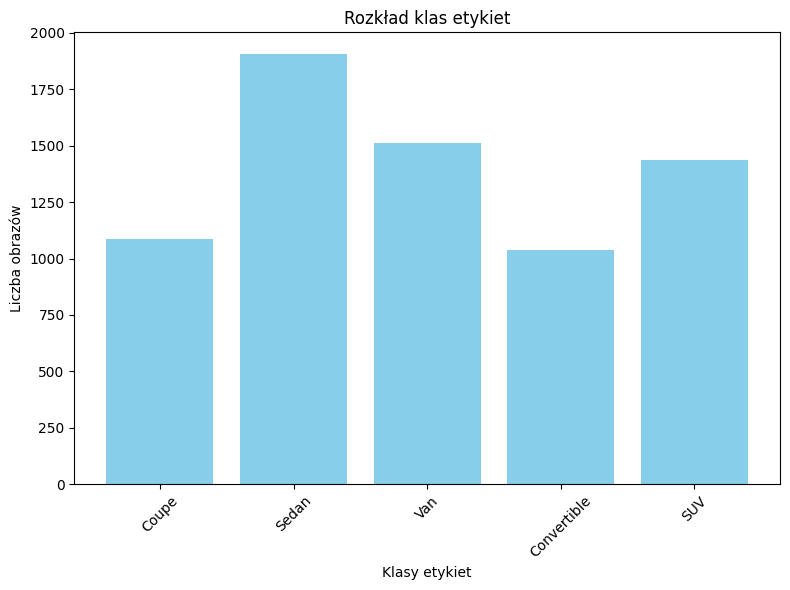

In [ ]:
csv_file = 'data/stanford_cars_type.csv'
data_csv = pd.read_csv(csv_file)
print(data_csv.head())
labelsPlot(data_csv['car_type'])
data_csv['car_type'].replace('Minivan', 'Van', inplace=True)

data_csv['car_type'].replace('Wagon', 'Van', inplace=True)

data_csv['car_type'].replace('Cab', 'Van', inplace=True)

data_csv = data_csv[~data_csv['car_type'].isin(['Other', 'Hatchback'])]

labelsPlot(data_csv['car_type'])

data_csv.to_csv('data/new_stanford_cars_type.csv', index=False)

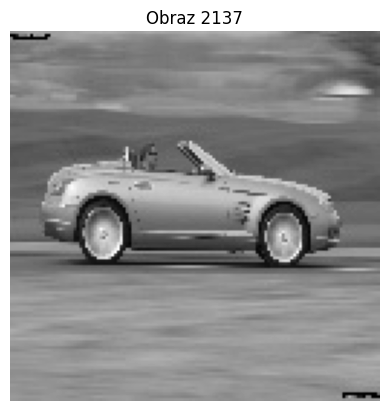

In [7]:
# Indeks obrazu do wyświetlenia
index_to_display = 2137  # Możesz zmienić indeks, aby wyświetlić inny obraz

# Wyświetlenie wybranego obrazu
plt.imshow(images[index_to_display], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
plt.axis('off')  # Wyłączenie osi
plt.title(f"Obraz {index_to_display}")
plt.show()

#### Split dataset

In [5]:
images, labels = loadImage('128x128')
labelsPlot(labels)
labels_encoded, labels_encoder = encodeLabel(labels)
print(labels_encoded.shape)
print(images.shape)
imagesProc = preprocessImages(images)

X_train, X_test, y_train, y_test = train_test_split(imagesProc, labels_encoded, test_size=0.2, stratify=labels_encoded)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

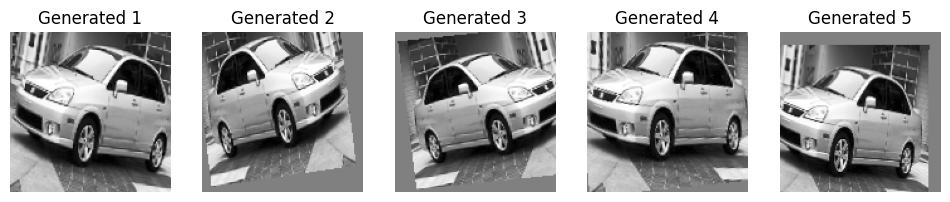

In [18]:
# resizeAndSaveImages('processed','64x64',(64,64))

# chosen_index = 345  # Indeks wybranego zdjęcia
# generate_image_histogram_by_index(images, labels, chosen_index)
# generate_image_histogram_by_index(imagesProc, labels, chosen_index)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=127
)


img = X_train[0]
img = np.expand_dims(img, axis=0)  # Dodanie dodatkowego wymiaru
img = img * 255.
flow = datagen.flow(img, batch_size=1)

# Generowanie kilku obrazów za pomocą ImageDataGenerator
generated_images = [next(flow)[0].astype(np.uint8).reshape(X_train[0].shape) for _ in range(5)] 

# Wyświetlenie wygenerowanych obrazów
plt.figure(figsize=(12, 6))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Generated {i + 1}')
    plt.axis('off')

plt.show()

### Sieć Zero: Prosta sieć bez generacji, potężny overfit

Epoch 1/5
204/204 [==============================] - 149s 724ms/step - loss: 3.2879 - accuracy: 0.2203 - val_loss: 2.0593 - val_accuracy: 0.2370
Epoch 2/5
204/204 [==============================] - 150s 734ms/step - loss: 1.6322 - accuracy: 0.4573 - val_loss: 2.0468 - val_accuracy: 0.2713
Epoch 3/5
204/204 [==============================] - 149s 733ms/step - loss: 0.8466 - accuracy: 0.7566 - val_loss: 2.2884 - val_accuracy: 0.2664
Epoch 4/5
204/204 [==============================] - 148s 725ms/step - loss: 0.2544 - accuracy: 0.9558 - val_loss: 2.7031 - val_accuracy: 0.2591
Epoch 5/5
204/204 [==============================] - 148s 725ms/step - loss: 0.0717 - accuracy: 0.9954 - val_loss: 3.1928 - val_accuracy: 0.2345


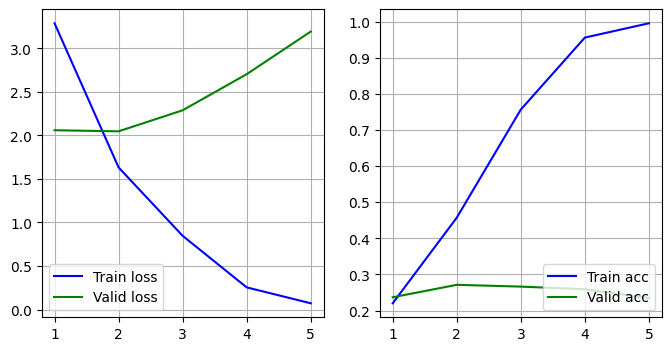

51/51 - 5s - loss: 3.1928 - accuracy: 0.2345 - 5s/epoch - 103ms/step

Test accuracy: 0.23449969291687012


In [9]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(labels_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

### Siec nr 1 zwykła sekwencyjna (napisana funkcyjnie, ale sekwenyjna)

Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


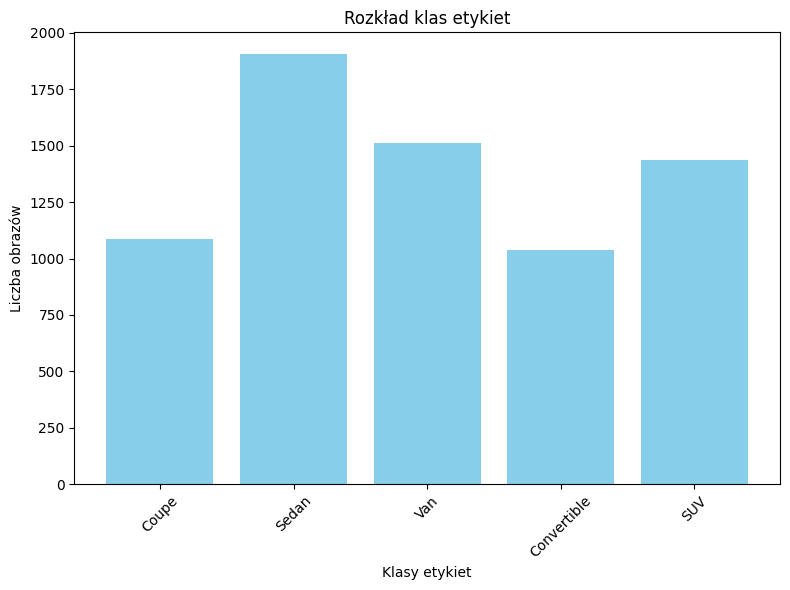

(6981,)
(6981, 128, 128)


In [26]:
images, labels = loadImage('128x128')
labelsPlot(labels)
labels_encoded, labels_encoder = encodeLabel(labels)
print(labels_encoded.shape)
print(images.shape)
imagesProc = preprocessImages(images)

X_train, X_test, y_train, y_test = train_test_split(imagesProc, labels_encoded, test_size=0.2, stratify=labels_encoded)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

['Convertible' 'Coupe' 'SUV' 'Sedan' 'Van']
{0: 1.3471652593486128, 1: 1.2836781609195402, 2: 0.9711304347826087, 3: 0.732327868852459, 4: 0.9229752066115703}
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                           

C:\Users\Cezary\AppData\Local\Temp\ipykernel_2296\570990041.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


87/87 [==============================] - 60s 679ms/step - loss: 1.6121 - accuracy: 0.1946 - val_loss: 1.5914 - val_accuracy: 0.2777
Epoch 2/5
87/87 [==============================] - 60s 693ms/step - loss: 1.5989 - accuracy: 0.2283 - val_loss: 1.5886 - val_accuracy: 0.2391
Epoch 3/5
87/87 [==============================] - 59s 682ms/step - loss: 1.5703 - accuracy: 0.2589 - val_loss: 1.5220 - val_accuracy: 0.3121
Epoch 4/5
87/87 [==============================] - 60s 690ms/step - loss: 1.5352 - accuracy: 0.2888 - val_loss: 1.4838 - val_accuracy: 0.3200
Epoch 5/5
87/87 [==============================] - 61s 695ms/step - loss: 1.5047 - accuracy: 0.3111 - val_loss: 1.4374 - val_accuracy: 0.3450
{'loss': [1.6120957136154175, 1.5989137887954712, 1.5702613592147827, 1.535172700881958, 1.5046719312667847], 'accuracy': [0.19456522166728973, 0.22826087474822998, 0.2588768005371094, 0.28876811265945435, 0.3110507130622864], 'val_loss': [1.5914419889450073, 1.5886297225952148, 1.5220329761505127, 

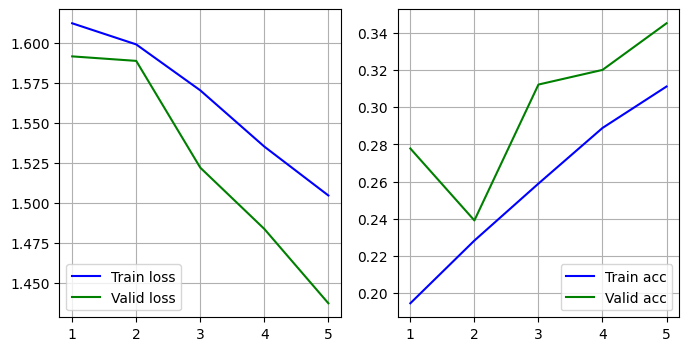

44/44 - 3s - loss: 1.4374 - accuracy: 0.3450 - 3s/epoch - 76ms/step

Test accuracy: 0.34502506256103516


In [30]:
input_shape = X_train.shape[1:]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Konwersja wag klas na słownik
class_weight_dict = dict(enumerate(class_weights))
print(labels_encoder.classes_)
print(class_weight_dict)

input_layer = Input(shape=input_shape)

# Warstwa konwolucyjna 1
conv1 = Conv2D(64, (5, 5), activation='relu')(input_layer)
max_pool1 = MaxPooling2D((2, 2))(conv1)

# Warstwa konwolucyjna 2
conv2 = Conv2D(64, (3, 3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D((2, 2))(conv3)

# Warstwa spłaszczająca
flatten = Flatten()(max_pool3)

# Warstwa dropout
dropout = Dropout(0.2)(flatten)

# Warstwa gęsta 1
dense1 = Dense(128, activation='relu')(dropout)

# Warstwa wyjściowa
output_layer = Dense(len(labels_encoder.classes_), activation='softmax')(dense1)

# Tworzenie modelu
model = Model(inputs=input_layer, outputs=output_layer)
print(model.summary())

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tworzenie instancji ImageDataGenerator do augmentacji danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Ustawienie generatora dla danych treningowych
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# Ustawienie callbacku do zapisywania modelu
# checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{modelsDir}model.h5', save_best_only=True)

# Trenowanie modelu z użyciem generatora
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//64,
    epochs=15,
    validation_data=(X_test, y_test),
    # callbacks=[checkpoint],
    class_weight=class_weight_dict
)

# Wyświetlenie wyników
plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/5


C:\Users\Cezary\AppData\Local\Temp\ipykernel_2296\4200192597.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


87/87 [==============================] - 57s 658ms/step - loss: 1.2039 - accuracy: 0.4734 - val_loss: 1.2401 - val_accuracy: 0.4445
Epoch 2/5
87/87 [==============================] - 60s 690ms/step - loss: 1.2090 - accuracy: 0.4649 - val_loss: 1.2812 - val_accuracy: 0.4288
Epoch 3/5
87/87 [==============================] - 61s 697ms/step - loss: 1.1824 - accuracy: 0.4730 - val_loss: 1.3209 - val_accuracy: 0.4059
Epoch 4/5
87/87 [==============================] - 60s 684ms/step - loss: 1.1706 - accuracy: 0.4870 - val_loss: 1.1588 - val_accuracy: 0.4953
Epoch 5/5
87/87 [==============================] - 61s 697ms/step - loss: 1.1392 - accuracy: 0.4976 - val_loss: 1.1767 - val_accuracy: 0.4903
{'loss': [1.203932523727417, 1.2090400457382202, 1.1823911666870117, 1.1706218719482422, 1.1391814947128296], 'accuracy': [0.4733695685863495, 0.4648550748825073, 0.4730072319507599, 0.48695650696754456, 0.49764493107795715], 'val_loss': [1.2400528192520142, 1.2812268733978271, 1.3209017515182495, 1

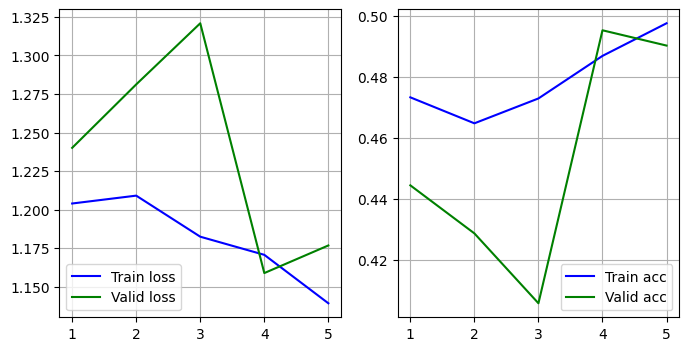

44/44 [==============================] - 3s 76ms/step
Accuracy: 0.490336435218325
Precision: 0.4979360214477863
Recal: 0.490336435218325
F1 Score: 0.4895415317580803


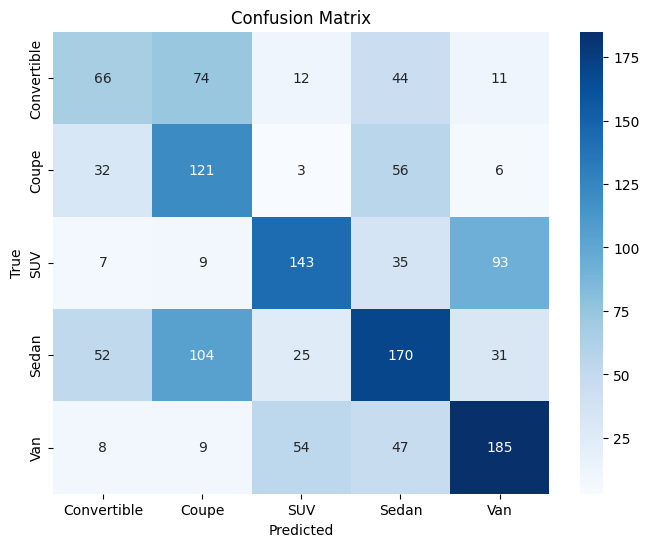

In [44]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//64,
    epochs=5,
    validation_data=(X_test, y_test),
    # callbacks=[checkpoint],
    class_weight=class_weight_dict
)

# Wyświetlenie wyników
plotPrint(history)
confMatrixSingle(model, X_test, y_test, labels_encoder)
# # Ocena modelu na danych testowych
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
# print(f'\nTest accuracy: {test_acc}')

44/44 [==============================] - 3s 76ms/step
Accuracy: 0.490336435218325
Precision: 0.4979360214477863
Recal: 0.490336435218325
F1 Score: 0.4895415317580803


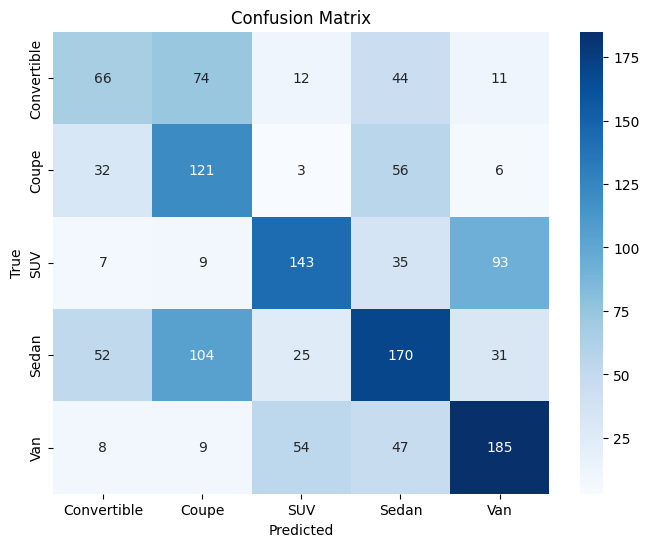

In [45]:
confMatrixSingle(model, X_test, y_test, labels_encoder)

In [46]:
saveModel(model=model, model_name='nr1')

Model został zapisany pod nazwą: nr1


### Siec nr 2 z wycztaniem i przygotowaniem laebli dla wielu wyjść 

Index(['Nazwa_pliku', 'Klasa'], dtype='object')
Counter({'Coupe': 1907, 'Sedan': 1907, 'Van': 1907, 'Convertible': 1907, 'SUV': 1907})


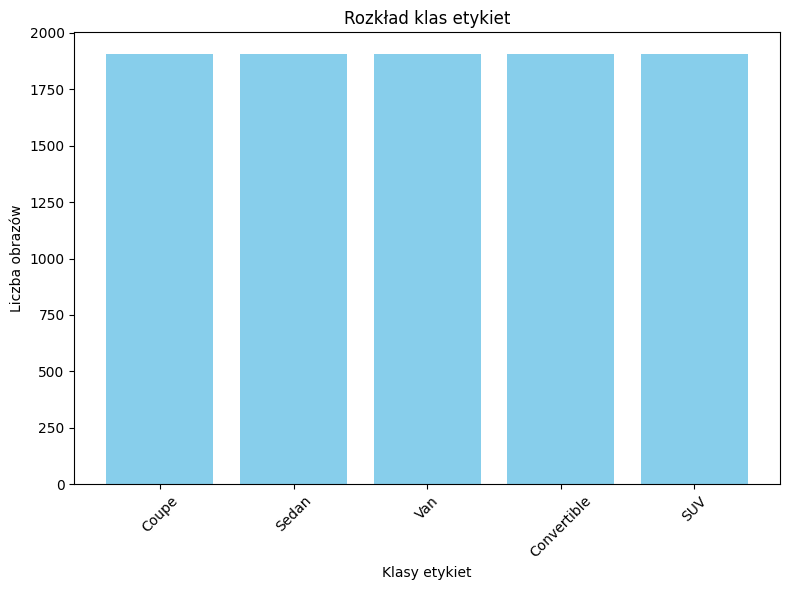

(9535,)
(9535, 128, 128)


In [47]:
images, labels = loadImageGenerated('128x128')
labelsPlot(labels)
labels_encoded, labels_encoder = encodeLabel(labels)
print(labels_encoded.shape)
print(images.shape)
imagesProc = preprocessImages(images)

In [48]:

np.set_printoptions(edgeitems=10)

X_train, X_test, y_train, y_test = train_test_split(imagesProc, labels, test_size=0.2, stratify=labels)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))


# Stworzenie kopii etykiet
labels_general = np.array(y_train.copy())
labels_small = np.array(y_train.copy())
labels_big = np.array(y_train.copy())

labels_general_test = np.array(y_test.copy())
labels_small_test = np.array(y_test.copy())
labels_big_test = np.array(y_test.copy())

# Zamiana określonych etykiet na 'small'
labels_general[np.isin(labels_general, ['Coupe', 'Sedan', 'Convertible'])] = 'small'

# Zamiana pozostałych etykiet na 'big'
labels_general[np.isin(labels_general, ['SUV', 'Van'])] = 'big'

labels_small[np.isin(labels_general, ['big'])] = None
labels_big[np.isin(labels_general, ['small'])] = None

labels_general_test[np.isin(labels_general_test, ['Coupe', 'Sedan', 'Convertible'])] = 'small'

# Zamiana pozostałych etykiet na 'big'
labels_general_test[np.isin(labels_general_test, ['SUV', 'Van'])] = 'big'

labels_small_test[np.isin(labels_general_test, ['big'])] = None
labels_big_test[np.isin(labels_general_test, ['small'])] = None

# Wydrukowanie oryginalnych i zmienionych etykiet
# print("Oryginalne etykiety:")
# print(labels)

# print("\nZmienione labels_general:")
# print(labels_general)

# print("\nZmienione labels_small:")
# print(labels_small)

# print("\nZmienione labels_big:")
# print(labels_big)

labels_encoded_small, labels_encoder_small = encodeLabel(labels_small)
y_labels_small = to_categorical(labels_encoded_small, num_classes=4)

labels_encoded_small_test = labels_encoder_small.transform(labels_small_test)
y_labels_small_test = to_categorical(labels_encoded_small_test, num_classes=4)


labels_encoded_big, labels_encoder_big = encodeLabel(labels_big)
y_labels_big = to_categorical(labels_encoded_big, num_classes=3)

labels_encoded_big_test = labels_encoder_big.transform(labels_big_test)
y_labels_big_test = to_categorical(labels_encoded_big_test, num_classes=3)


labels_encoded_general, labels_encoder_general = encodeLabel(labels_general)
y_labels_general = to_categorical(labels_encoded_general, num_classes=2)

labels_encoded_general_test = labels_encoder_general.transform(labels_general_test)
y_labels_general_test = to_categorical(labels_encoded_general_test, num_classes=2)


labels_encoded_finale, labels_encoder_finale = encodeLabel(y_train)
y_labels_finale = to_categorical(labels_encoded_finale, num_classes=5)

labels_encoded_finale_test = labels_encoder_finale.transform(y_test)
y_labels_finale_test = to_categorical(labels_encoded_finale_test, num_classes=5)

print(f'len: {len(y_labels_small)} {len(y_labels_general)} {len(y_labels_big)} {len(labels_encoded_finale)} ')

# print(y_train)
# print(y_labels_finale)
# print(y_test)
# print(y_labels_finale_test)

len: 7628 7628 7628 7628 


(7628, 128, 128, 1) (7628, 4)


C:\Users\Cezary\AppData\Local\Temp\ipykernel_5412\1694240925.py:228: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cars.fit_generator(


Epoch 1/15
476/476 [==============================] - 210s 436ms/step - loss: 4.5641 - output_general_loss: 0.6726 - output_specific_small_loss: 1.3447 - output_specific_large_loss: 0.9500 - output_final_loss: 1.5968 - output_general_accuracy: 0.6029 - output_specific_small_accuracy: 0.4007 - output_specific_large_accuracy: 0.5993 - output_final_accuracy: 0.2383 - val_loss: 4.3707 - val_output_general_loss: 0.6453 - val_output_specific_small_loss: 1.2912 - val_output_specific_large_loss: 0.9085 - val_output_final_loss: 1.5257 - val_output_general_accuracy: 0.6172 - val_output_specific_small_accuracy: 0.4185 - val_output_specific_large_accuracy: 0.5999 - val_output_final_accuracy: 0.3015
Epoch 2/15
476/476 [==============================] - 207s 436ms/step - loss: 4.3866 - output_general_loss: 0.6466 - output_specific_small_loss: 1.2838 - output_specific_large_loss: 0.9188 - output_final_loss: 1.5373 - output_general_accuracy: 0.6287 - output_specific_small_accuracy: 0.4124 - output_spe

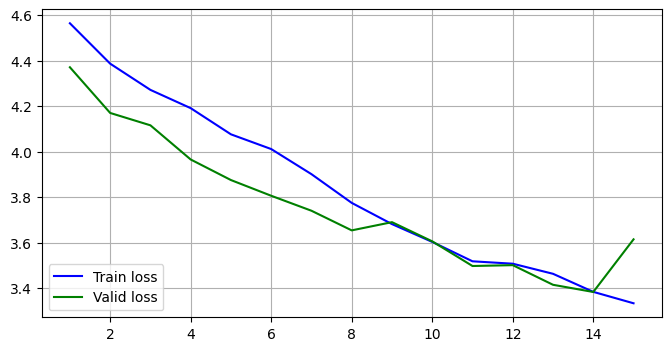

In [25]:
#Taka testowa sieć, ta niżej jest lepsza 
input_shape = X_train.shape[1:]


class_weights_general = compute_class_weight('balanced', classes=np.unique(labels_encoded_general), y=labels_encoded_general)
class_weight_dict_general = dict(enumerate(class_weights_general))

class_weights_specific_small = compute_class_weight('balanced', classes=np.unique(labels_encoded_small), y=labels_encoded_small)
class_weight_dict_specific_small = dict(enumerate(class_weights_specific_small))

class_weights_specific_large = compute_class_weight('balanced', classes=np.unique(labels_encoded_big), y=labels_encoded_big)
class_weight_dict_specific_large = dict(enumerate(class_weights_specific_large))

class_weights_final = compute_class_weight('balanced', classes=np.unique(labels_encoded_finale), y=labels_encoded_finale)
class_weight_dict_final = dict(enumerate(class_weights_final))

weight_dict = {
        'output_general': class_weight_dict_general,
        'output_specific_small': class_weight_dict_specific_small,
        'output_specific_large': class_weight_dict_specific_large,
        'output_final': class_weight_dict_final
    }
def weighted_binary_crossentropy(target, output, weights_table):
    # get the given weight
    weights_vect = weights_table.lookup(target)
    return K.sparse_categorical_crossentropy(target, output) * weights_vect

# transform dictionary of weights into lookup table that can be used
def to_lookup_table(dictionary):
    return tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            list({np.int64(key): value for key, value in dictionary.items()}), #[0,1]
            list(dictionary.values()), # corresponding weights
            key_dtype=tf.int64,
            value_dtype=tf.float32,
        ),
        default_value=-1)

cw1 = class_weight_dict_general
cw2 = class_weight_dict_specific_small
cw3 = class_weight_dict_specific_large
cw4 = class_weight_dict_final

# define function where weights_table already defined
binary_crossentropy_general = partial(weighted_binary_crossentropy, weights_table=to_lookup_table(class_weight_dict_general))
binary_crossentropy_small = partial(weighted_binary_crossentropy, weights_table=to_lookup_table(class_weight_dict_specific_small))
binary_crossentropy_big = partial(weighted_binary_crossentropy, weights_table=to_lookup_table(class_weight_dict_specific_large))
binary_crossentropy_finale = partial(weighted_binary_crossentropy, weights_table=to_lookup_table(class_weight_dict_final))
# Definicja wejścia
input_layer = Input(shape=input_shape, name='input_images')

# Pierwsza warstwa konwolucyjna dla ogólnego poziomu (samochody małe/duże)
conv_general1 = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_general1 = MaxPooling2D((2, 2))(conv_general1)

# Druga warstwa konwolucyjna dla ogólnego poziomu
conv_general2 = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_general1)
max_pool_general2 = MaxPooling2D((2, 2))(conv_general2)

# Warstwa spłaszczająca
flatten_general = Flatten()(max_pool_general2)

# Warstwa gęsta dla ogólnego poziomu
dense_general = Dense(128, activation='relu')(flatten_general)

# Warstwa wyjściowa dla ogólnego poziomu
output_general = Dense(2, activation='softmax', name='output_general')(dense_general)


# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody małe)
conv_specific1_small = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_specific1_small = MaxPooling2D((2, 2))(conv_specific1_small)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_small = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_small)
max_pool_specific2_small = MaxPooling2D((2, 2))(conv_specific2_small)

# Warstwa spłaszczająca
flatten_specific_small = Flatten()(max_pool_specific2_small)

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_small = Dense(128, activation='relu')(flatten_specific_small)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody małe)
output_specific_small = Dense(4, activation='softmax', name='output_specific_small')(dense_specific_small)


# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody duże)
conv_specific1_large = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_specific1_large = MaxPooling2D((2, 2))(conv_specific1_large)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_large = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_large)
max_pool_specific2_large = MaxPooling2D((2, 2))(conv_specific2_large)

# Warstwa spłaszczająca
flatten_specific_large = Flatten()(max_pool_specific2_large)

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_large = Dense(128, activation='relu')(flatten_specific_large)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody duże)
output_specific_large = tf.keras.layers.Dense(3, activation='softmax', name='output_specific_large')(dense_specific_large)


# Połączenie obu wyjść
merged = concatenate([dense_general, dense_specific_small, dense_specific_large])

# Warstwa gęsta dla końcowego wyjścia
final_dense = Dense(256, activation='relu')(merged)

# Warstwa wyjściowa końcowa
output_layer = Dense(5, activation='softmax', name='output_final')(final_dense)

# Model dla samochodów
model_cars = tf.keras.models.Model(inputs=input_layer, outputs=[output_general, output_specific_small, output_specific_large, output_layer])

# Skompiluj model z odpowiednimi funkcjami straty dla każdej kategorii
model_cars.compile(optimizer='adam',
                    loss={'output_general': 'sparse_categorical_crossentropy',
                          'output_specific_small': 'sparse_categorical_crossentropy',
                          'output_specific_large': 'sparse_categorical_crossentropy',
                          'output_final': 'sparse_categorical_crossentropy'},
                    # loss={'output_general': binary_crossentropy_general,
                    #       'output_specific_small': binary_crossentropy_small,
                    #       'output_specific_large': binary_crossentropy_big,
                    #       'output_final': binary_crossentropy_finale},
                    metrics=['accuracy'],
                    # class_weight={
                    #     'output_general': class_weight_dict_general,
                    #     'output_specific_small': class_weight_dict_specific_small,
                    #     'output_specific_large': class_weight_dict_specific_large,
                    #     'output_final': class_weight_dict_final
                    # }
                    )


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)


def custom_data_generator(X_train, y_train, encoder_finale, encoder_small, encoder_big, encoder_general,batch_size=16):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.5
    )

    # data = {'input_images': X_train, 'output_general': y_labels_general, 'output_specific_small': y_labels_small,
    #         'output_specific_large': y_labels_big, 'output_final': y_labels_finale}

    generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    while True:
        batch = generator.next()
        batch_inputs = batch[0]
        batch_outputs = {
            'output_general': encoder_general.transform(batch[1]),
            'output_specific_small': encoder_small.transform(batch[1]),
            'output_specific_large': encoder_big.transform(batch[1]),
            'output_final': encoder_finale.transform(batch[1]),
        }
        yield batch_inputs, batch_outputs

def custom_data_generator2(X_train, y_train, encoded_finale, encoded_small, encoded_big, encoded_general,batch_size=16):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.5
    )

    # data = {'input_images': X_train, 'output_general': y_labels_general, 'output_specific_small': y_labels_small,
    #         'output_specific_large': y_labels_big, 'output_final': y_labels_finale}
    size = len(y_train)
    idx = list(range(size))
    generator = datagen.flow(X_train, idx, batch_size=batch_size)

    while True:
        batch = generator.next()
        batch_inputs = batch[0]
        batch_outputs = {
            'output_general': encoded_general[batch[1]],
            'output_specific_small': encoded_small[batch[1]],
            'output_specific_large': encoded_big[batch[1]],
            'output_final': encoded_finale[batch[1]],
        }
        yield batch_inputs, batch_outputs


data = {'input_images': X_train, 'output_general': labels_encoded_general, 'output_specific_small': labels_encoded_small, 'output_specific_large': labels_encoded_big, 'output_final': labels_encoded_finale}
x_train_list = data['input_images'] 
y_train_list = [data['output_general'], data['output_specific_small'], data['output_specific_large'], data['output_final']]
y_general_list = [data['output_general']]
y_specific_small_list = [data['output_specific_small']]
y_specific_large_list = [data['output_specific_large']]
y_final_list = [data['output_final']]

# print(np.asarray(x_train_list).transpose(1, 0, 2, 3, 4))

train_label = np.array([labels_encoded_general,labels_encoded_small,labels_encoded_big,labels_encoded_finale]).T
print(x_train_list.shape, train_label.shape)
# print(train_label)
# train_generator = train_datagen.flow(x_train_list,train_label
#     , batch_size=16)


train_generator = custom_data_generator(X_train,y_train,encoder_finale=labels_encoder_finale,encoder_big=labels_encoder_big,encoder_general=labels_encoder_general,encoder_small=labels_encoder_small,batch_size=16)
train_generator2 = custom_data_generator2(X_train,y_train,encoded_finale=labels_encoded_finale,encoded_big=labels_encoded_big,encoded_general=labels_encoded_general,encoded_small=labels_encoded_small,batch_size=16)

# Trenowanie modelu z użyciem generatora
history = model_cars.fit_generator(
    train_generator2,
    steps_per_epoch=len(X_train)//16,
    epochs=15,
    validation_data=(X_test, {'output_general': labels_encoded_general_test, 'output_specific_small': labels_encoded_small_test, 'output_specific_large': labels_encoded_big_test, 'output_final': labels_encoded_finale_test}),
    # class_weight=weight_dict['output_final']
)

# history = model_cars.fit(
#     X_train,
#     {'output_general': y_labels_general, 'output_specific_small': y_labels_small, 'output_specific_large': y_labels_big, 'output_final': y_labels_finale},
#     epochs=5,
#     validation_data=(X_test, {'output_general': y_labels_general_test, 'output_specific_small': y_labels_small_test, 'output_specific_large': y_labels_big_test, 'output_final': y_labels_finale_test}),
#     # class_weight=class_weight_dict,
#     batch_size=16
# )

# Wyświetlenie wyników
plotPrint(history)

# # Ocena modelu na danych testowych
# test_loss, test_acc = model_cars.evaluate(X_test, y_test, verbose=2)
# print(f'\nTest accuracy: {test_acc}')

C:\Users\Cezary\AppData\Local\Temp\ipykernel_2296\4112456498.py:120: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cars.fit_generator(


Epoch 1/15
119/119 [==============================] - 158s 1s/step - loss: 4.7410 - output_general_loss: 0.6931 - output_specific_small_loss: 1.3947 - output_specific_large_loss: 1.0123 - output_final_loss: 1.6410 - output_general_accuracy: 0.5986 - output_specific_small_accuracy: 0.3892 - output_specific_large_accuracy: 0.5969 - output_final_accuracy: 0.2093 - val_loss: 4.4676 - val_output_general_loss: 0.6412 - val_output_specific_small_loss: 1.2894 - val_output_specific_large_loss: 0.9424 - val_output_final_loss: 1.5945 - val_output_general_accuracy: 0.6245 - val_output_specific_small_accuracy: 0.4074 - val_output_specific_large_accuracy: 0.5999 - val_output_final_accuracy: 0.2386
Epoch 2/15
119/119 [==============================] - 153s 1s/step - loss: 4.4386 - output_general_loss: 0.6520 - output_specific_small_loss: 1.2771 - output_specific_large_loss: 0.9344 - output_final_loss: 1.5750 - output_general_accuracy: 0.6189 - output_specific_small_accuracy: 0.4145 - output_specific_

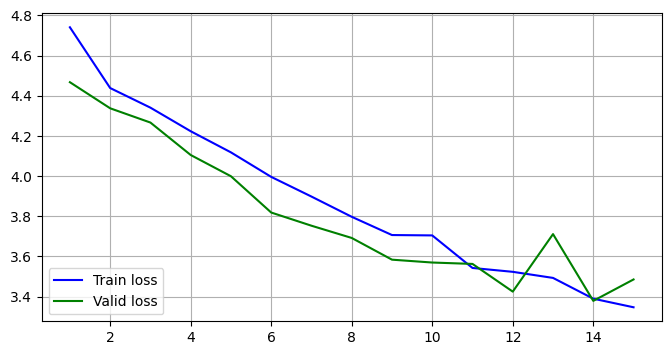

In [6]:
#Sieć ne 2. napisana funkcyjnie z kilkoma wyjsciami 

input_shape = X_train.shape[1:]

# Definicja wejścia
input_layer = Input(shape=input_shape, name='input_images')

# Pierwsza warstwa konwolucyjna dla ogólnego poziomu (samochody małe/duże)
conv_general1 = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_general1 = MaxPooling2D((2, 2))(conv_general1)

# Druga warstwa konwolucyjna dla ogólnego poziomu
conv_general2 = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_general1)
max_pool_general2 = MaxPooling2D((2, 2))(conv_general2)

# Warstwa spłaszczająca
flatten_general = Flatten()(max_pool_general2)

# Warstwa gęsta dla ogólnego poziomu
dense_general = Dense(128, activation='relu')(flatten_general)

# Warstwa wyjściowa dla ogólnego poziomu
output_general = Dense(2, activation='softmax', name='output_general')(dense_general)



# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody małe)
conv_specific1_small = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_specific1_small = MaxPooling2D((2, 2))(conv_specific1_small)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_small = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_small)
max_pool_specific2_small = MaxPooling2D((2, 2))(conv_specific2_small)

# Warstwa spłaszczająca
flatten_specific_small = Flatten()(max_pool_specific2_small)

merged_general_small = concatenate([dense_general, flatten_specific_small])

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_small = Dense(128, activation='relu')(merged_general_small)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody małe)
output_specific_small = Dense(4, activation='softmax', name='output_specific_small')(dense_specific_small)


# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody duże)
conv_specific1_large = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
max_pool_specific1_large = MaxPooling2D((2, 2))(conv_specific1_large)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_large = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_large)
max_pool_specific2_large = MaxPooling2D((2, 2))(conv_specific2_large)

# Warstwa spłaszczająca
flatten_specific_large = Flatten()(max_pool_specific2_large)

merged_general_large = concatenate([dense_general, flatten_specific_large])

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_large = Dense(128, activation='relu')(merged_general_large)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody duże)
output_specific_large = tf.keras.layers.Dense(3, activation='softmax', name='output_specific_large')(dense_specific_large)


# Połączenie obu wyjść
merged = concatenate([dense_general, dense_specific_small, dense_specific_large])

# Warstwa gęsta dla końcowego wyjścia
final_dense = Dense(32, activation='relu')(merged)

# Warstwa wyjściowa końcowa
output_layer = Dense(5, activation='softmax', name='output_final')(final_dense)

# Model dla samochodów
model_cars = tf.keras.models.Model(inputs=input_layer, outputs=[output_general, output_specific_small, output_specific_large, output_layer])

# Skompiluj model z odpowiednimi funkcjami straty dla każdej kategorii
model_cars.compile(optimizer='adam',
                    loss={'output_general': 'sparse_categorical_crossentropy',
                          'output_specific_small': 'sparse_categorical_crossentropy',
                          'output_specific_large': 'sparse_categorical_crossentropy',
                          'output_final': 'sparse_categorical_crossentropy'},
                    metrics=['accuracy'],
                    )


def custom_data_generator2(X_train, y_train, encoded_finale, encoded_small, encoded_big, encoded_general,batch_size=16):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.5
    )

    size = len(y_train)
    idx = list(range(size))
    generator = datagen.flow(X_train, idx, batch_size=batch_size)

    while True:
        batch = generator.next()
        batch_inputs = batch[0]
        batch_outputs = {
            'output_general': encoded_general[batch[1]],
            'output_specific_small': encoded_small[batch[1]],
            'output_specific_large': encoded_big[batch[1]],
            'output_final': encoded_finale[batch[1]],
        }
        yield batch_inputs, batch_outputs


train_generator2 = custom_data_generator2(X_train,y_train,encoded_finale=labels_encoded_finale,encoded_big=labels_encoded_big,encoded_general=labels_encoded_general,encoded_small=labels_encoded_small,batch_size=64)

# Trenowanie modelu z użyciem generatora
history = model_cars.fit_generator(
    train_generator2,
    steps_per_epoch=len(X_train)//64,
    epochs=15,
    validation_data=(X_test, {'output_general': labels_encoded_general_test, 'output_specific_small': labels_encoded_small_test, 'output_specific_large': labels_encoded_big_test, 'output_final': labels_encoded_finale_test}),
)

plotPrint(history)

Model został wczytany z pliku: nr2


C:\Users\Cezary\AppData\Local\Temp\ipykernel_2296\2369737578.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cars.fit_generator(


Epoch 1/5
119/119 [==============================] - 160s 1s/step - loss: 2.9561 - output_general_loss: 0.3823 - output_specific_small_loss: 0.8831 - output_specific_large_loss: 0.5918 - output_final_loss: 1.0988 - output_general_accuracy: 0.8304 - output_specific_small_accuracy: 0.6174 - output_specific_large_accuracy: 0.7556 - output_final_accuracy: 0.5249 - val_loss: 2.6677 - val_output_general_loss: 0.3299 - val_output_specific_small_loss: 0.8382 - val_output_specific_large_loss: 0.5067 - val_output_final_loss: 0.9929 - val_output_general_accuracy: 0.8558 - val_output_specific_small_accuracy: 0.6397 - val_output_specific_large_accuracy: 0.7986 - val_output_final_accuracy: 0.5773
Epoch 2/5
119/119 [==============================] - 153s 1s/step - loss: 2.9399 - output_general_loss: 0.3768 - output_specific_small_loss: 0.8817 - output_specific_large_loss: 0.5877 - output_final_loss: 1.0937 - output_general_accuracy: 0.8318 - output_specific_small_accuracy: 0.6235 - output_specific_la

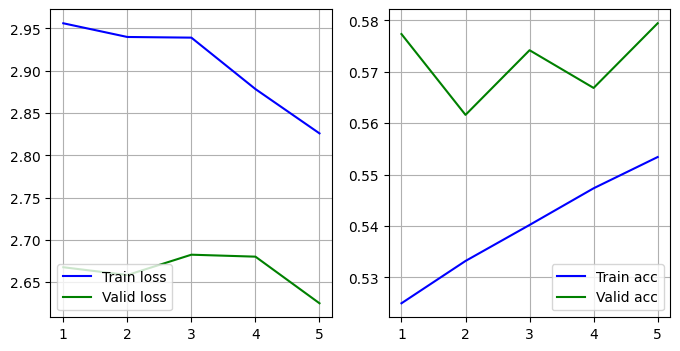

60/60 [==============================] - 8s 127ms/step
Accuracy: 0.5794441531200839
Precision: 0.6001653992436967
Recal: 0.5794441531200839
F1 Score: 0.5731544555942759


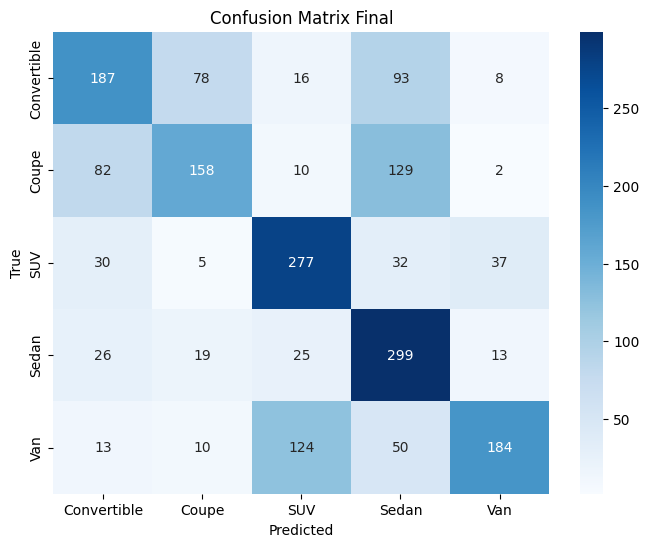

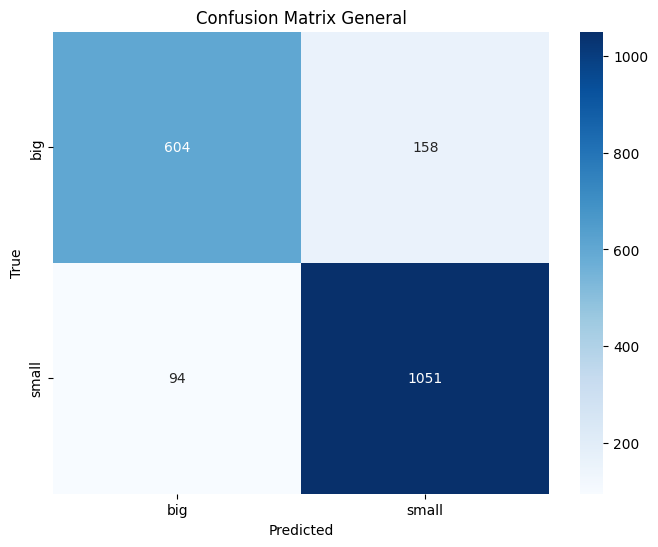

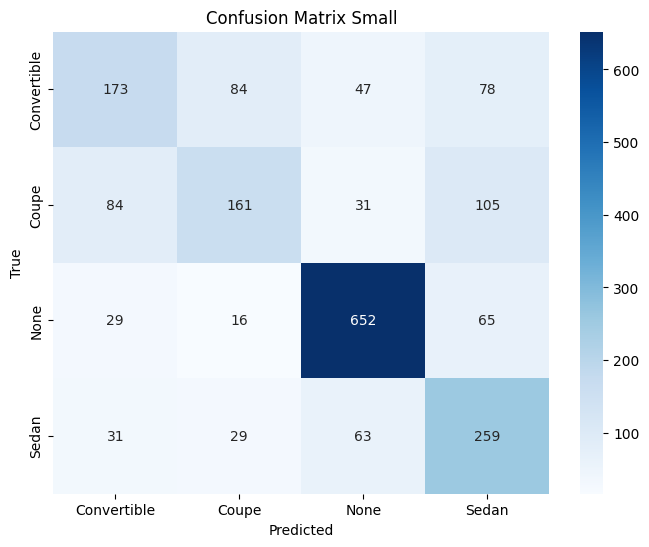

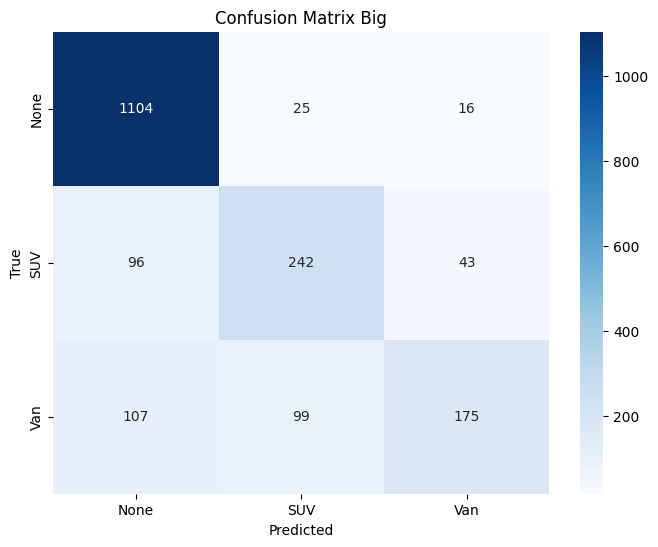

In [50]:

model_cars2 = loadModel('nr2')

def custom_data_generator2(X_train, y_train, encoded_finale, encoded_small, encoded_big, encoded_general,batch_size=16):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.5
    )
    
    size = len(y_train)
    idx = list(range(size))
    generator = datagen.flow(X_train, idx, batch_size=batch_size)

    while True:
        batch = generator.next()
        batch_inputs = batch[0]
        batch_outputs = {
            'output_general': encoded_general[batch[1]],
            'output_specific_small': encoded_small[batch[1]],
            'output_specific_large': encoded_big[batch[1]],
            'output_final': encoded_finale[batch[1]],
        }
        yield batch_inputs, batch_outputs
        
train_generator2 = custom_data_generator2(X_train,y_train,encoded_finale=labels_encoded_finale,encoded_big=labels_encoded_big,encoded_general=labels_encoded_general,encoded_small=labels_encoded_small,batch_size=64)

history = model_cars.fit_generator(
    train_generator2,
    steps_per_epoch=len(X_train)//64,
    epochs=5,
    validation_data=(X_test, {'output_general': labels_encoded_general_test, 'output_specific_small': labels_encoded_small_test, 'output_specific_large': labels_encoded_big_test, 'output_final': labels_encoded_finale_test}),
)

# Wyświetlenie wyników
plotPrint(history)
confMatrixMultiOutput(model_cars, X_test,
    labels_dict={'general': labels_encoded_general_test, 'small': labels_encoded_small_test, 'big': labels_encoded_big_test, 'final': labels_encoded_finale_test}, 
    encoder_dict={'general': labels_encoder_general, 'small': labels_encoder_small, 'big': labels_encoder_big, 'final': labels_encoder_finale})


Epoch 1/5


C:\Users\Cezary\AppData\Local\Temp\ipykernel_2296\498151017.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cars.fit_generator(


119/119 [==============================] - 149s 1s/step - loss: 3.1066 - output_general_loss: 0.4130 - output_specific_small_loss: 0.9300 - output_specific_large_loss: 0.6248 - output_final_loss: 1.1387 - output_general_accuracy: 0.8135 - output_specific_small_accuracy: 0.5988 - output_specific_large_accuracy: 0.7444 - output_final_accuracy: 0.5148 - val_loss: 3.1562 - val_output_general_loss: 0.4016 - val_output_specific_small_loss: 0.9552 - val_output_specific_large_loss: 0.6364 - val_output_final_loss: 1.1630 - val_output_general_accuracy: 0.8243 - val_output_specific_small_accuracy: 0.5868 - val_output_specific_large_accuracy: 0.7383 - val_output_final_accuracy: 0.5071
Epoch 2/5
119/119 [==============================] - 150s 1s/step - loss: 3.0410 - output_general_loss: 0.4014 - output_specific_small_loss: 0.9051 - output_specific_large_loss: 0.6150 - output_final_loss: 1.1196 - output_general_accuracy: 0.8207 - output_specific_small_accuracy: 0.6108 - output_specific_large_accura

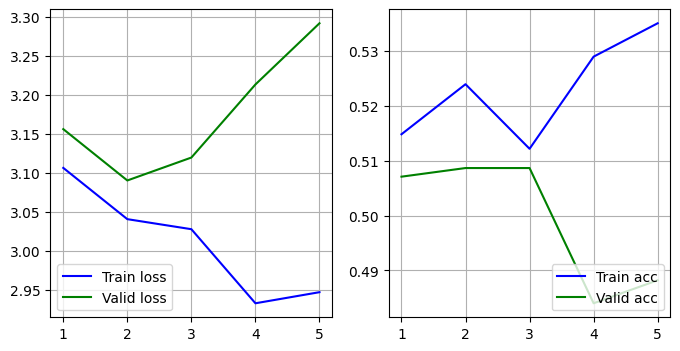

60/60 [==============================] - 8s 128ms/step
Accuracy: 0.48820136339800735
Precision: 0.5251279319772523
Recal: 0.48820136339800735
F1 Score: 0.4784138162746313


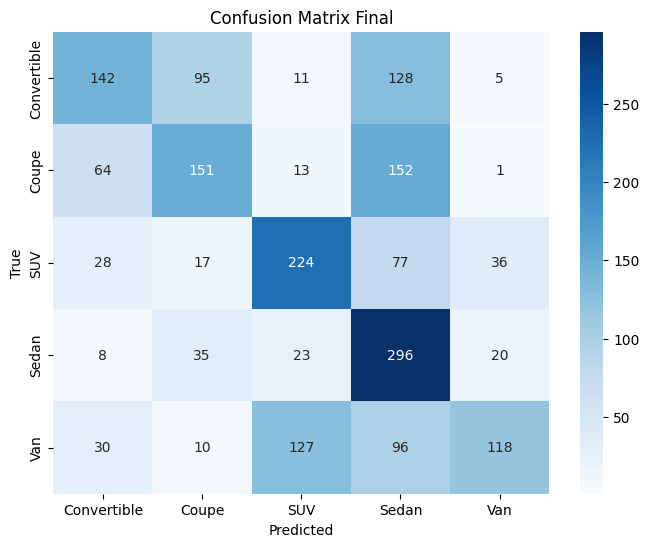

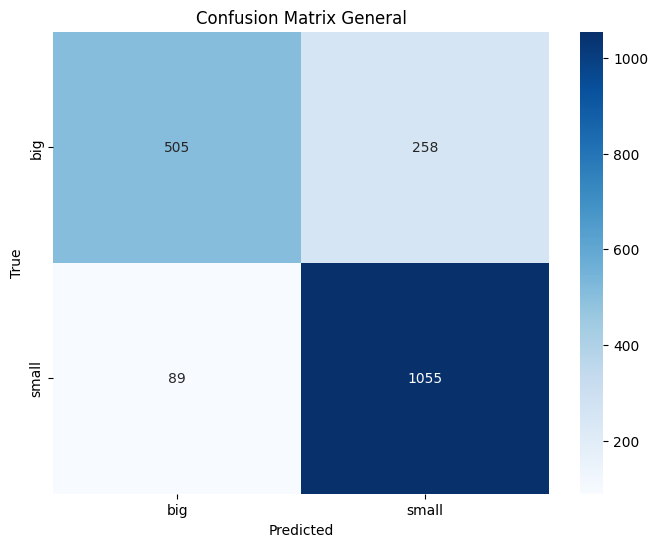

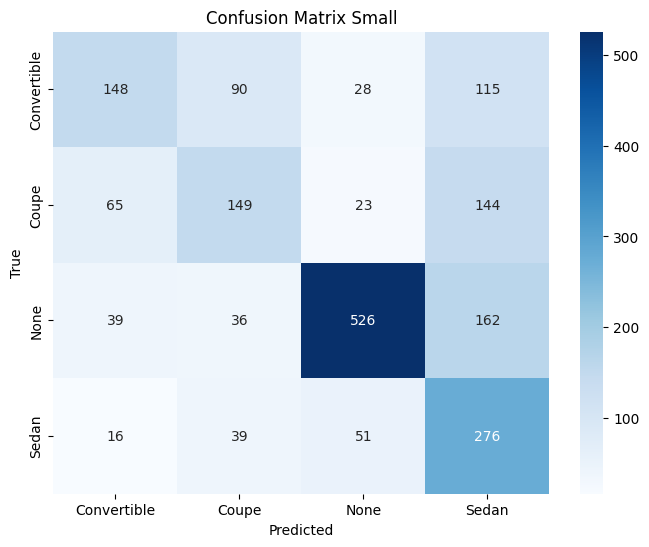

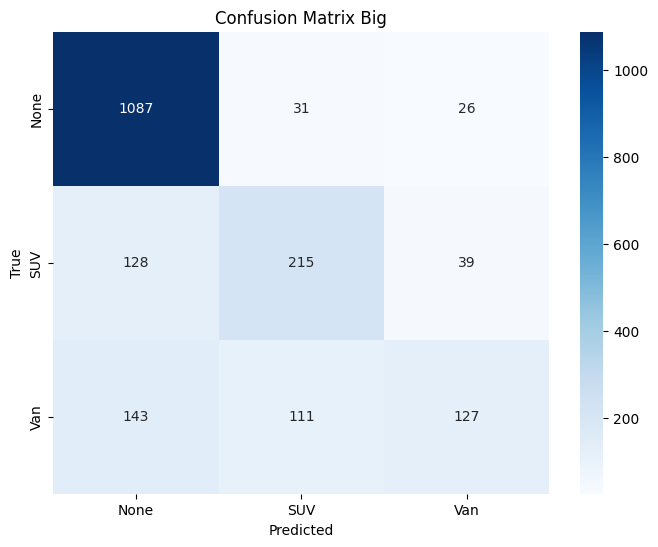

In [24]:
history = model_cars.fit_generator(
    train_generator2,
    steps_per_epoch=len(X_train)//64,
    epochs=5,
    validation_data=(X_test, {'output_general': labels_encoded_general_test, 'output_specific_small': labels_encoded_small_test, 'output_specific_large': labels_encoded_big_test, 'output_final': labels_encoded_finale_test}),
)

# Wyświetlenie wyników
plotPrint(history)
confMatrixMultiOutput(model_cars, X_test,
    labels_dict={'general': labels_encoded_general_test, 'small': labels_encoded_small_test, 'big': labels_encoded_big_test, 'final': labels_encoded_finale_test}, 
    encoder_dict={'general': labels_encoder_general, 'small': labels_encoder_small, 'big': labels_encoder_big, 'final': labels_encoder_finale})


{'loss': [2.956125497817993, 2.93992280960083, 2.939143180847168, 2.8783371448516846, 2.8259477615356445], 'output_general_loss': [0.38232871890068054, 0.37682777643203735, 0.3853548765182495, 0.3743385970592499, 0.36296406388282776], 'output_specific_small_loss': [0.8831163048744202, 0.8816716074943542, 0.8783245086669922, 0.8594450354576111, 0.8509274125099182], 'output_specific_large_loss': [0.5918354988098145, 0.587676465511322, 0.587350606918335, 0.57676100730896, 0.5585205554962158], 'output_final_loss': [1.0988441705703735, 1.0937474966049194, 1.0881134271621704, 1.0677919387817383, 1.0535361766815186], 'output_general_accuracy': [0.8303571343421936, 0.8318350315093994, 0.8299841284751892, 0.836329996585846, 0.8367266058921814], 'output_specific_small_accuracy': [0.6173844337463379, 0.6234796643257141, 0.6180592179298401, 0.6302220821380615, 0.637493371963501], 'output_specific_large_accuracy': [0.7556459903717041, 0.753437340259552, 0.7597832083702087, 0.7633527517318726, 0.766

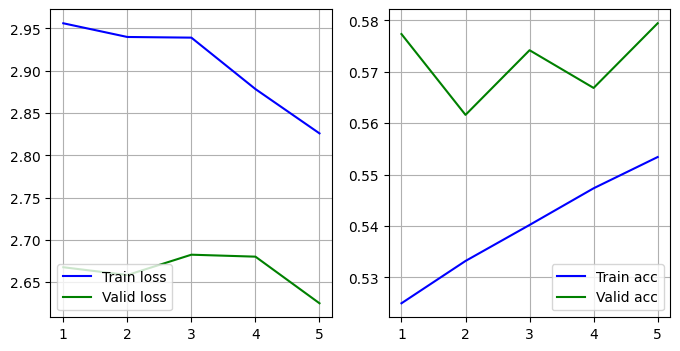

60/60 [==============================] - 8s 133ms/step
Accuracy: 0.5794441531200839
Precision: 0.6001653992436967
Recal: 0.5794441531200839
F1 Score: 0.5731544555942759


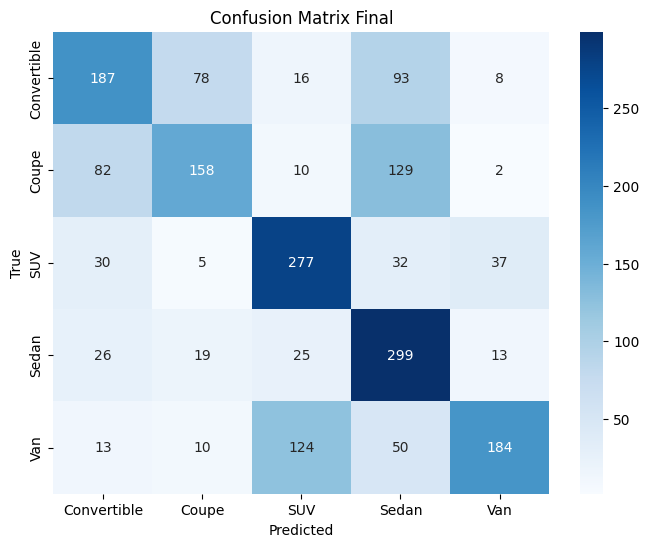

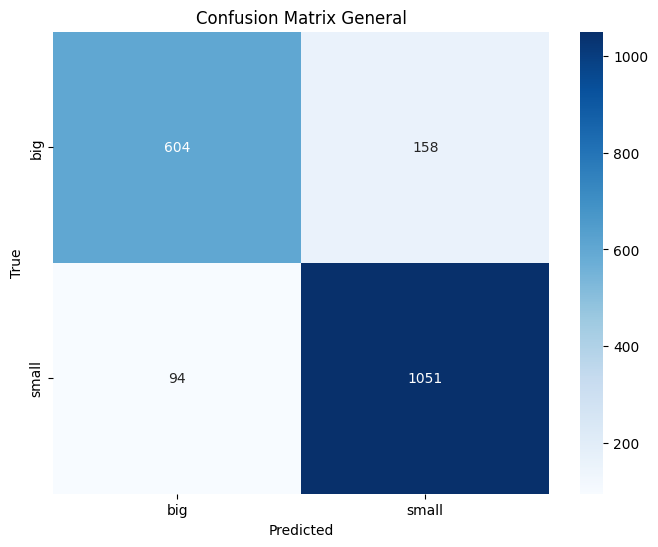

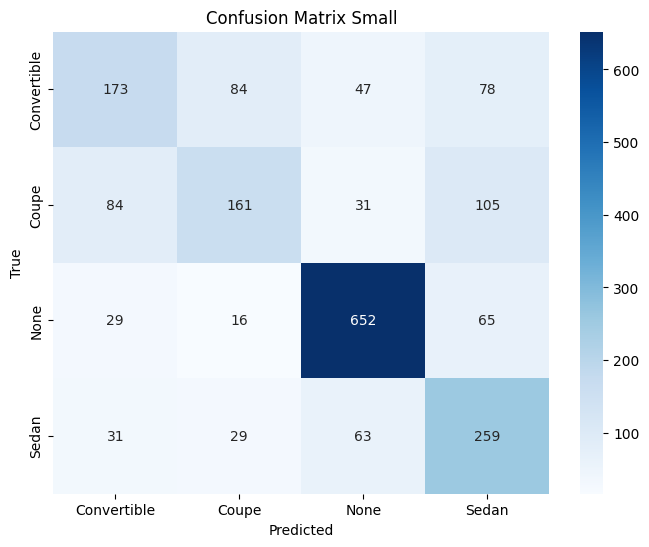

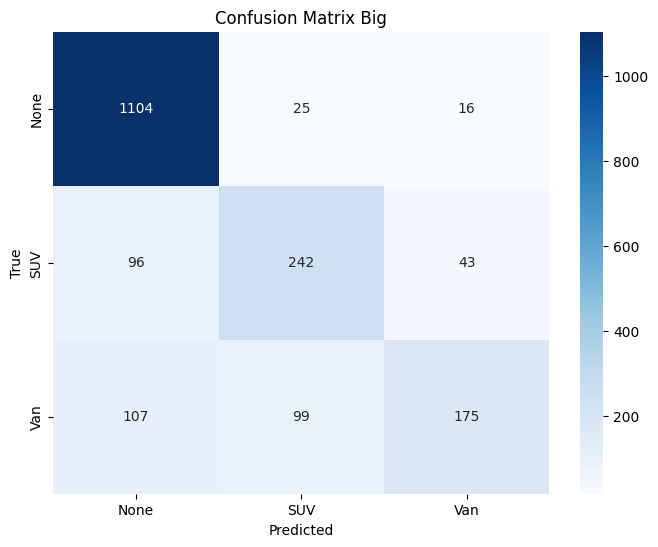

In [51]:
plotPrint(history)
confMatrixMultiOutput(model_cars, X_test,
    labels_dict={'general': labels_encoded_general_test, 'small': labels_encoded_small_test, 'big': labels_encoded_big_test, 'final': labels_encoded_finale_test}, 
    encoder_dict={'general': labels_encoder_general, 'small': labels_encoder_small, 'big': labels_encoder_big, 'final': labels_encoder_finale})

In [52]:
saveModel(model=model_cars, model_name='nr2')

Model został zapisany pod nazwą: nr2
